In [1]:
import astropy.units as u
from astropy.time import Time
import copy
import numpy as np
from os.path import abspath, dirname, join
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astroquery.vizier import Vizier
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import (
    GroundFrame,
    TiltedGroundFrame,
    NominalFrame,
    TelescopeFrame,
    CameraFrame,
    EngineeringCameraFrame,
)

In [3]:
from CHECLabPy.core.io import HDF5Reader, HDF5Writer
from CHECOnsky.scripts_analysis.add_pointing_to_hillas import LOCATION, \
    EngineeringCameraFrame, calculate_alpha
from CHECLabPySB import get_data
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord, AltAz
from astropy import units as u


FOCAL_LENGTH = u.Quantity(2.1500001, u.m)


def get_telescope_pointing(df_pointing):
    obstime = df_pointing['t_cpu']
    alt = (df_pointing['altitude_raw'] +
           df_pointing['altitude_cor']).values
    az = (df_pointing['azimuth_raw'] +
          df_pointing['azimuth_cor']).values
    altaz_frame = AltAz(location=LOCATION, obstime=obstime)
    return SkyCoord(
        alt=alt,
        az=az,
        unit='rad',
        frame=altaz_frame,
    )


def get_engineering_frame(telescope_pointing):
    return EngineeringCameraFrame(
        n_mirrors=2,
        location=LOCATION,
        obstime=telescope_pointing.obstime,
        focal_length=FOCAL_LENGTH,
        telescope_pointing=telescope_pointing,
    )


def get_camera_coords(df_source, telescope_pointing, engineering_frame, angle):
    source_ra = df_source['source_ra']
    source_dec = df_source['source_dec']

    source_skycoord = SkyCoord(source_ra, source_dec, unit='deg', frame='icrs')
    if angle.value == 0:
        off_skycoord = source_skycoord
    else:
        position_angle = telescope_pointing.position_angle(
            source_skycoord
        ).to(u.deg) - angle
        seperation = telescope_pointing.separation(source_skycoord)
        off_skycoord = telescope_pointing.directional_offset_by(
            position_angle=position_angle,
            separation=seperation
        )

    off_cam = off_skycoord.transform_to(engineering_frame)
    x_off = off_cam.x.value
    y_off = off_cam.y.value
    return x_off, y_off


In [4]:
ss_image = np.load('/Users/Jason/Software/CHECLabPySB/CHECLabPySB/d190607_pointing/DracoIm.npy')

In [19]:
stars = SkyCoord([
    (269.151667, 51.488889), 
    (262.608333, 52.301389),
    (263.066667, 55.173056),
    (263.044167, 55.184167)
] * u.deg, frame='icrs')

In [22]:
# Define pointing
#location=EarthLocation.from_geodetic(lon=14.974609, lat=37.693267, height=1750)
obstime=Time("2019-05-09T01:37:54.728026")

altaz_frame = AltAz(location=LOCATION, obstime=obstime)

alt = 73.21 * u.deg
az = 0.5 * u.deg

telescope_pointing = SkyCoord(
    alt=alt, 
    az=az, 
    frame=altaz_frame,
)
engineering_frame = get_engineering_frame(telescope_pointing)

In [23]:
# Get pixel coordinates from TargetCalib
from target_calib import CameraConfiguration
camera_config = CameraConfiguration("1.1.0")
m = camera_config.GetMapping()

xpix = np.array(m.GetXPixVector()) * u.m
ypix = np.array(m.GetYPixVector()) * u.m
size = m.GetSize() * u.m
area = size**2
pix_area = np.full(xpix.size, area) * area.unit

engineering_camera_geom = CameraGeometry(
    "CHEC",
    pix_id=np.arange(xpix.size),
    pix_x=xpix,
    pix_y=ypix,
    pix_area=pix_area,
    pix_type='rectangular',
    frame=engineering_frame
)

In [8]:
# Get stars
stars_eng = stars.transform_to(engineering_frame)

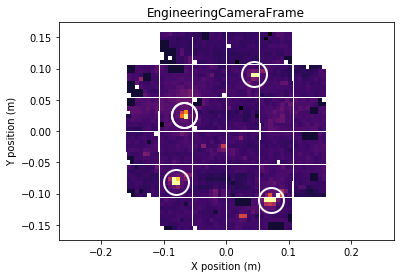

In [26]:
display_camera = CameraDisplay(
    engineering_camera_geom, 
    image=ss_image,
    title="EngineeringCameraFrame",
    cmap='inferno'
)
display_camera.set_limits_minmax(-10, 100)

plt.plot(stars_eng.x.value, stars_eng.y.value, 'wo', color='white', mfc='none', ms=25, mew=2)